In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from data import *
import pretrainedmodels
import torchvision.transforms as transforms
import sys
import glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import json
from tqdm import tqdm_notebook
from senet import *
from collections import OrderedDict
import gc
gc.enable()

Using TensorFlow backend.


In [2]:
nw = 4   #number of workers for data loader
# TOT = 46613580 - 340000

NCATS = 340
NUM_EACH_CLASS = 20000
TOT = NCATS * NUM_EACH_CLASS
EPOCHS = 50
size = 71
SIZE = size # for matching to imagenet
batchsize = 256 
lw = 6
STEPS = int(NUM_EACH_CLASS * NCATS / EPOCHS / batchsize)

channel = 3

device = torch.device("cuda:0")

In [3]:
class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride
        
class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(3, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [2]:
en_dict = {}
path = '../input/train_raw/'

filenames = glob.glob(os.path.join(path, '*.csv'))
filenames = sorted(filenames)

def encode_files():
    """ Encode all label by name of csv_files """
    counter = 0
    for fn in filenames:
        en_dict[fn[:-4].split('/')[-1].replace(' ', '_')] = counter
        counter += 1
        
# collect file names and encode label
encode_files()

dec_dict = {v: k for k, v in en_dict.items()}
def decode_labels(label):
    return dec_dict[label]

def get_label(nfile):
    """ Return encoded label for class by name of csv_files """
    return en_dict[nfile.replace(' ', '_')[:-4]]

def get_label_by_word(word):
    return en_dict[word.replace(' ', '_')]

In [5]:
class DoodlesDataset(Dataset):
    """Doodles csv dataset."""

    def __init__(self, csv_file, root_dir, mode='train', nrows=1000, skiprows=None, size=256, transform=None):
        self.root_dir = root_dir
        file = os.path.join(self.root_dir, csv_file)
        self.size = size
        self.mode = mode
        usecols = ['drawing','word'] if mode == 'train' else ['drawing']
        usecols += ['recognized']
        self.doodle = pd.read_csv(file, usecols=usecols, nrows=nrows, skiprows=skiprows)
        # only recognized
        self.doodle = self.doodle.loc[self.doodle.recognized == True]
        self.transform = transform
#         if self.mode == 'train':
#             self.label = get_label(csv_file)

    @staticmethod
    def _draw(raw_strokes, size=256, lw=6, time_color=True):
        img = draw_time_encoding(raw_strokes, size = size, lw = lw)
        return np.transpose(img, (2, 0, 1))
    
    def __len__(self):
        return len(self.doodle)

    def __getitem__(self, idx):
        raw_strokes = json.loads(self.doodle.drawing[idx])
        sample = self._draw(raw_strokes, size=self.size, lw=6, time_color=True)
        if self.transform:
            sample = self.transform(sample)
#         print(sample.shape, sample[None].shape)
        if self.mode == 'train':
            return (sample/255).astype('float32'), get_label_by_word(self.doodle.word[idx])
        else:
            return (sample/255).astype('float32')

In [6]:
import ntpath

select_nrows = NUM_EACH_CLASS
skip_rows = NUM_EACH_CLASS * 5
end_rows = skip_rows + select_nrows

def calc_skip(lines):
    if lines < end_rows:
        ret = abs(end_rows - lines)
        if (lines - ret) < select_nrows:
            ret = lines - select_nrows
        return ret
    else:
        return skip_rows

line_cnt = pd.read_csv('../input/line_cnts.csv')
line_cnt['skip_rows'] = line_cnt['line'].apply(calc_skip)
line_cnt['val_skip_rows'] = line_cnt['line'].apply(lambda x : x - 100)

In [7]:

# collect all single csvset in one

doodle_all = ConcatDataset([DoodlesDataset(fn.split('/')[-1], path, nrows=select_nrows, size=SIZE,
              skiprows=range(1, line_cnt.loc[line_cnt.file == ntpath.split(fn)[1], 'skip_rows'].values[0])) 
                            for fn in filenames])

In [8]:
validationset = DoodlesDataset('valid_raw.csv', 
                               root_dir = '../input/', 
                               nrows=None, size=SIZE)

In [9]:
# total images in set
print('Train set:', len(doodle_all))
print('Validation set:', len(validationset))
# Use the torch dataluuoader to iterate through the dataset
loader = DataLoader(doodle_all, batch_size=batchsize, shuffle=True, num_workers=1)
valid_loader = DataLoader(validationset, batch_size=16, shuffle=False, num_workers=1)

Train set: 6799890
Validation set: 34000


In [10]:
len(valid_loader)

2125

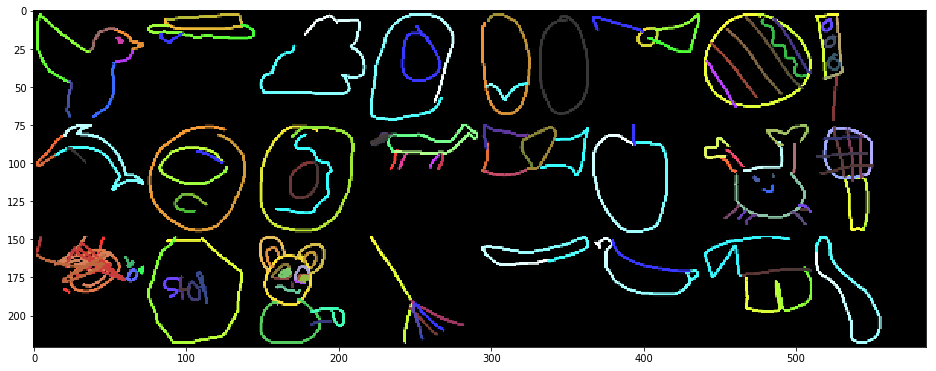

In [11]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some images 
dataiter = iter(loader)
images, label = dataiter.next()

# show images
plt.figure(figsize=(16,24))
imshow(torchvision.utils.make_grid(images[:24]))

In [12]:
# validation function 
def validation(lossf, scoref):
    model.eval()
    loss, score = 0, 0
    vlen = len(valid_loader)
    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss += lossf(output, y).item()
        score += scoref(output, y)[0].item()
    model.train()
    return loss/vlen, score/vlen

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [13]:
model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=NCATS)



In [14]:
model_prefix = 'se_resnext50_raw_all3_{}'.format(SIZE)
MODEL_CKPT = 'models/best_{}.pth'.format(model_prefix)
print(MODEL_CKPT)

models/best_se_resnext50_raw_all3_71.pth


In [15]:
last_path= 'models/se_resnext50_detail_end.pth' 
if os.path.exists(last_path):
    print('load from last_path', last_path)
    model.load_state_dict(torch.load(last_path, map_location=lambda storage, loc: storage))
elif os.path.exists(MODEL_CKPT):
    print('load from check point', MODEL_CKPT)
    model.load_state_dict(torch.load(MODEL_CKPT, map_location=lambda storage, loc: storage))

load from last_path models/se_resnext50_detail_end.pth


In [16]:
# if torch.cuda.device_count() > 1:
#   print("Let's use", torch.cuda.device_count(), "GPUs!")
#   model = nn.DataParallel(model)

In [17]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.00004)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience = 2)

model = model.to(device)

In [ ]:
epochs = 1
lsize = len(loader) 
itr = 1
p_itr = int(lsize / 10) # print every N iteration
patience = 5

print('p_itr', p_itr)

# if os.path.exists(MODEL_CKPT):
#     print('load previous trained weights', MODEL_CKPT)
#     model.load_state_dict(torch.load(MODEL_CKPT, map_location=lambda storage, loc: storage))
model.train()

best_score = 0
lr_patient = 0
valid_patient = 0
cycle = 0
lr_min = 0.00001
lr_max = 0.001
lr_rampdown = 65

for epoch in range(epochs):
    tloss, score = 0, 0
    for x, y in tqdm_notebook(loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        tloss += loss.item()
        score += accuracy(output, y)[0].item()
        
        if itr%p_itr==0:
            vloss, vscore = validation(criterion, accuracy)
            print('Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(itr, tloss/p_itr, score/p_itr))
            print('Iteration {} -> Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(itr, vloss, vscore))
            print('next validation:', itr + p_itr)
            time.sleep(0.1)
            
#             exp_lr_scheduler.step(vscore)
            
            if vscore >= best_score:
                lr_patient = 0
                valid_patient = 0
                best_score = vscore
                
                model.eval()
                torch.save(model.state_dict(), MODEL_CKPT)
                model.train()
                
                print('new best_score{:.3f}'.format(vscore), 'save to', MODEL_CKPT)
            else:
                lr_patient += 1
                valid_patient += 1
                
            if valid_patient >=  15:
                cycle += 1
                lr_patient = 0
                valid_patient = 0
                
                checkpath = 'models/se_resnext50_parts_cycle{}.pth'.format(cycle)
                model.eval()
                torch.save(model.state_dict(), checkpath)
                model.train()

                print('rampdown')
                for params in optimizer.param_groups:
                    params['lr'] = (lr_min + 0.5 * (lr_max - lr_min) *
                                   (1 + np.cos(np.pi * t_ / lr_rampdown)))

                print('Learning rate set to {:.4}'.format(optimizer.param_groups[0]['lr']))

            if lr_patient >= patience:
                print('Reducing learning rate by {}'.format(0.5))
                for params in optimizer.param_groups:
                    params['lr'] *= 0.5
                lr_patient = 0
                
            tloss, score = 0, 0 
             
        itr +=1
vloss, vscore = validation(criterion, accuracy)
print('Final -> Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(vloss, vscore))

model.eval()
torch.save(model.state_dict(), 'models/se_resnext50_detail_end.pth')

p_itr 2656


Iteration 2656 -> Train Loss: 0.5870, Accuracy: 84.44%
Iteration 2656 -> Validation Loss: 0.6137, Accuracy: 83.99%
next validation: 5312
new best_score83.988 save to models/best_se_resnext50_raw_all3_71.pth


In [ ]:
model.load_state_dict(torch.load(MODEL_CKPT, map_location=lambda storage, loc: storage))
model = model.eval() 

In [ ]:
SIZE

In [ ]:
testset = DoodlesDataset('test_raw.csv', '../input', mode='test', nrows=None, size=SIZE)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
labels = np.empty((0,3))
for x in tqdm_notebook(testloader):
    x = x.to(device)
    output = model(x)
    _, pred = output.topk(3, 1, True, True)
    labels = np.concatenate([labels, pred], axis = 0)

In [ ]:
submission = pd.read_csv('../input/test_raw.csv', index_col='key_id')
submission.drop(['countrycode', 'drawing'], axis=1, inplace=True)
submission['word'] = ''
prog = tqdm_notebook(total = len(submission))
for i, label in enumerate(labels):
    prog.update(1)
    submission.word.iloc[i] = " ".join([decode_labels(l) for l in label])

In [ ]:
import kaggle_util
kaggle_util.save_result(submission,  
                        '../result/{}.csv'.format(model_prefix), 
                         'quickdraw-doodle-recognition', 
                        send=True, index=True)

In [ ]:
x.shape

In [ ]:
pres = np.empty((0,340))
for x in tqdm_notebook(testloader):
    x = x.to(device)
    output = model(x)
    pres = np.concatenate([pres, output.detach().cpu().numpy()], axis = 0)
    
pres.shape

In [ ]:
swaps = [
    (18,19),
    (130,129),
    (156,155),
]

for pair in swaps:
    temp = np.copy(pres[:,pair[0]])
    pres[:,pair[0]] = pres[:,pair[1]]
    pres[:,pair[1]] = temp

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
pre_softmax = softmax(pres.T).T

In [ ]:
np.save('../result/pre_{}.npy'.format(model_prefix), pre_softmax)

In [ ]:
model_prefix